# Optimal Ballot Clustering

# Dependencies and Utility Functions

In [1]:
import math
import random

import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from sklearn_extra.cluster import KMedoids

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import gurobipy as gp
from gurobipy import GRB

import pickle
from itertools import permutations, combinations, chain
from tqdm import tqdm

In [2]:
# This file contains functions for analyzing elections and clustering ballots. 
#This is copied from mggg to give me easy access to knowing what their functions are/do

# An elections is represented as a dictionary matching ballots to weights.
#   For example `{(1,3,4):5, (1): 7}` is the election where $5$ people cast the ballot $(1,3,4)$
#   while $7$ people cast the bullet vote for candidate $1$.  
#   The candidates are always named $1,2,...n$.

# A clustering of an election means a partition its ballots.  
#   Each cluster (each piece of the partition) is itself an election, 
#   so the clustering is represented as a list of elections.  

def remove_zeros(ballot):
    """
    Helper function for parse.
    """
    to_return = []
    for vote in ballot:
        if vote != 0:
            to_return.append(vote)
    return tuple(to_return)

def parse(filename):
    """
    Returns a tuple (election, names, location) obtained from parsing the format in which Scottish election data is stored.
        
    The returned election is a dictionary matching ballots to weights.  For example {(1,3,4):5, (1): 7} is the election where 5 people cast the ballot (1,3,4) while 7 people cast the bullet vote for candidate 1.
    
    The candidates are coded 1,2,...n in the ballots of the returned election.  The returned names tells the corresponding candidate names. 

    Args:
        filename : name of file (.csv or .blt) containing the Scottish election data.
    
    Returns:
        tuple: election, names, location.
    """

    election = {}
    names = []
    numbers = True
    with open(filename, "r") as file:
        for line in file:
            s = line.rstrip("\n").rstrip()
            if numbers:
                ballot = [int(vote) for vote in s.split(" ")]
                num_votes = ballot[0]
                if num_votes == 0:
                    numbers = False
                else:
                    election[remove_zeros(ballot[1:])] = num_votes
            elif "(" not in s:
                return election, names, s.strip("\"")
            else:
                name_parts = s.strip("\"").split(" ")
                first_name = " ".join(name_parts[:-2])
                last_name = name_parts[-2]
                party = name_parts[-1].strip("(").strip(")")
                names.append((first_name, last_name, party))
    raise Exception(f"Error parsing file '{filename}'.")

def print_color(text,n): # print the text in the color associated to the integer index n.
    """
    Helper function for Summarize_election
    """
    black_code = "\033[00m"
    color_code = f"\033[{91+n}m"
    print(color_code,text,black_code)    

def Summarize_election(election, clusters=None, size=10):
    """
    Prints basic data about the given election including num candidates, num ballots, num distinct ballots, average ballot length, and the 10 (or any number) most often cast ballots.

    If a clustering is also given, then it also prints this data saparately for each cluster and color codes by cluster the list of most commonly cast ballots.  

    Args:
        election : a dictionary matching ballots to weights (# times cast).
        clusters : a clustering (list of elections) that partition the ballots of the election. 
        size : The desired length of the list of the most commonly cast ballots.
    """
    all_ballots = [ballot for ballot in election.keys() if election[ballot]>0]
    num_ballots = len(all_ballots)
    candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
    num_cands = len(candidates)
    num_voters = sum([election[ballot] for ballot in all_ballots])
    mu = sum([len(ballot)*election[ballot] for ballot in election.keys()])/sum(election.values())
    print(f"This election has: {num_cands} candidates, {num_voters} ballots, {num_ballots} distinct ballots, {round(mu,2)} avg ballot length.")

    if not clusters==None:
        for cluster_num in range(len(clusters)):
            cluster = clusters[cluster_num]
            all_ballots_c = [ballot for ballot in cluster.keys() if cluster[ballot]>0]
            num_ballots_c = len(all_ballots_c)
            num_voters_c = sum([cluster[ballot] for ballot in all_ballots_c])
            mu_c = sum([len(ballot)*cluster[ballot] for ballot in cluster.keys()])/sum(cluster.values())           
            print_color(f"CLUSTER {cluster_num+1}: {num_voters_c} ballots, {num_ballots_c} distinct ballots, {round(mu_c,2)} avg ballot length.",cluster_num)
            
    print("Top ballots:")
    ls = sorted(set(election.values()))
    count = 0
    broken = False
    while not broken:
        val = ls.pop()        
        bs = [ballot for ballot in all_ballots if election[ballot]==val]
        for ballot in bs:
            if clusters == None:
                color = -91 # black
            else:
                assignments = [n for n in range(len(clusters)) if ballot in clusters[n].keys() and clusters[n][ballot]>0]
                if len(assignments)==1:
                    color = assignments[0]
                else:
                    color = -84 # black outliner to indicate multiple clusters
            print_color(f"\t {val} votes for {ballot}.", color)
            count +=1
            if count>size:
                broken = True
                break

def Plot_ballot_lengths(clusters, num_cands = 'Auto', filename=None):
    """
    Plots a histogram of the ballot lengths for the given election or clustering.

    If a clustering is given instead of an election, it superimposes histrograms for each cluster.  

    Args:
        clusters : either an election (a dictionary matching ballots to weights) or a clustering (a list of elections).
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        filename : to save the plot.
    """
    if type(clusters)==dict:
        clusters = [clusters]
    k = len(clusters)
    if num_cands == 'Auto':        
        all_ballots = [x for cluster in clusters for x in cluster] 
        num_cands = max([item for ranking in all_ballots for item in ranking])

    X = np.arange(num_cands)
    width = .7/k
    palat = ['grey','purple','tomato','orange','b','c','g', 'r', 'm', 'y', 'k']
    fig, ax = plt.subplots()

    for clust in range(k):
        Y = np.zeros(num_cands)
        for ballot, weight in clusters[clust].items():
            Y[len(ballot)-1]+=weight
        Y = Y/sum(clusters[clust].values())
        ax.bar(X+clust*width,Y, width=width, label = f"Cluster {clust+1}", color = palat[clust])
    ax.set_title('Ballot lengths')
    ax.set_xlabel('ballot length')
    plt.xticks(X+(width*(k-1)/2) ,X+1)
    plt.legend()
    if filename == None:
        plt.show()
    else:
        plt.savefig(filename)


def Borda_vector(ballot_or_election,num_cands='Auto', borda_style='bord'):
    # """
    # Returns the Borda vector of the given ballot or election.  The "Borda vector of an election" means the (weighted) sum of the Borda vectors of its ballots.

    # Set borda_style = 'standard' for the standard convention that, in an election with n candidates, awards n-k points to the candidate in position k, and awards zero points for missing candidates.
    
    # Set borda_style = 'bord' for  to use the "Conservative" convenction that awards n-k-1 points to the candidate in position k, and awards zero points for missing candidates.
    
    # Set borda_style = 'full_points' for  to use the "Averaged" convenction that every ballot awards exactly 1+2+\cdots+n Borda points; this is achieved for a short ballot by dividing the unawarded points equally among the missing candidates.

        
    # Args:
    #     ballot_or_election : a single ballot (tuple) or an election (dictionary matching ballots to weights)
    #     num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it, but only if an election is given, since a single ballot isn't enough to determine num_cands.
    #     borda_style : choice of {'standard', 'bord', 'full_points'}
     
    # Returns:
    #     the Borda vector (np.array) of the given ballot or election.                
    # """
    L = 1 if borda_style=='bord' else 0
    # Borda vector of a ballot
    if type(ballot_or_election) == tuple:
        if num_cands=='Auto':
            raise Exception("A single ballot is not enough to determine the number of candidates.")
        ballot = ballot_or_election
        to_return = [0 for _ in range(num_cands)]
        for count in range(len(ballot)):
            candidate = ballot[count]
            to_return[candidate-1] = num_cands-count - L
        if borda_style=='full_points':
            missing_cands = set(range(1,num_cands+1))-set(ballot)
            for candidate in missing_cands:
                to_return[candidate-1] += (len(missing_cands)+1)/2
            
    # Borda vector of an election
    else:
        election = ballot_or_election
        if num_cands == 'Auto':
            num_cands = max([item for ranking in election.keys() for item in ranking])

        to_return = [0 for _ in range(num_cands)]
        for ballot, ballot_weight in election.items():
            for count in range(len(ballot)):
                candidate = ballot[count]
                to_return[candidate-1] += ballot_weight*(num_cands-count-L)
            if borda_style=='full_points':
                missing_cands = set(range(1,num_cands+1))-set(ballot)
                for candidate in missing_cands:
                    to_return[candidate-1] += ballot_weight*(len(missing_cands)+1)/2
    
    return np.array(to_return)

def Borda_dist(CA, CB, num_cands = 'Auto', borda_style='bord', order = 1):
    # """
    # Returns the L^p distance between the Borda vectors of the given pair of ballots or elections,
    #     where p is called the order (for example, order=2 is the Euclidean distance).

    # Set borda_style = 'standard' for the standard convention that, in an election with n candidates, awards n-k points to the candidate in position k, and awards zero points for missing candidates.
    
    # Set borda_style = 'bord' for  to use the "Conservative" convenction that awards n-k+1 points to the candidate in position k, and awards zero points for missing candidates.
    
    # Set borda_style = 'full_points' for  to use the "Averaged" convenction that every ballot awards exactly 1+2+\cdots+n Borda points; this is achieved for a short ballot by dividing the unawarded points equally among the missing candidates.
    
    # Args:
    #     CA, CB : a pair of ballots (tuples) or elections (dictionaries matching ballots to weights).
    #     num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it,
    #                 but only if an election is given, since a ballot pair isn't enough to determine num_cands.
    #     borda_style : choice of {'standard', 'bord', 'full_points'}
    #     order : the choice of p with resepct to which the L^p distance is computed.
    
    # Returns:
    #     the L^p distance between the Borda vectors.                
    # """
    if num_cands == 'Auto':
        if type(CA) == tuple:
            raise Exception("A single pair of ballot is not enough to determine the number of candidates.")
        else:
            all_ballots = list(CA.keys())+list(CB.keys())
            num_cands = max([item for ranking in all_ballots for item in ranking])
            
    VA = Borda_vector(CA, num_cands=num_cands, borda_style=borda_style)
    VB = Borda_vector(CB, num_cands=num_cands, borda_style=borda_style)
    return np.linalg.norm(VA - VB,ord=order)

def Candidate_matrix(election, num_cands = 'Auto'):
    """
    Helper function for Plot_clusters   
    """
    # Creates a matrix M such that M[i-1][c-1] is the number of ith place votes received by candidate c.
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    
    to_return = np.zeros([num_cands,num_cands])
    for ballot in election.keys():
        ballot_weight = election[ballot]
        for ballot_position in range(len(ballot)):
            candidate = ballot[ballot_position]
            to_return[ballot_position][candidate-1] += ballot_weight
    return to_return

def Plot_clusters(clusters, method = 'Borda', borda_style='bord', num_cands = 'Auto', order = 'Auto', filename=None):
    """
    Displays a bar plot that helps visualize the given election or clustering.

    Args:
        election: either an election (a dictionary matching ballots to weights) or a clustering (a list of elections).
        method: either 'Borda' for a Borda plot, or 'Mentions' for a stacked mentions plot.
        borda_style: choice of {'bord', 'standard', 'full_points'}, which is passed to Borda_vector.
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        order : Set order='Auto' to order the candidates by deceasing Borda scores in the first cluster.  Set say order=[3,2,4,1] to order the candidates according to the given list. 
        filename : to save the plot.     
    """
    if type(clusters)==dict:
        clusters = [clusters]
    k = len(clusters)
    if num_cands == 'Auto':        
        all_ballots = [x for cluster in clusters for x in cluster] 
        num_cands = max([item for ranking in all_ballots for item in ranking])
    if method=='Borda':
        Scores = [Borda_vector(clusters[n], num_cands=num_cands, borda_style=borda_style) for n in range(k)]
    else:
        Scores = [Candidate_matrix(clusters[n], num_cands = num_cands) for n in range(k)]

    if type(order)==list:
        perm = [x-1 for x in order]
    if order=='Auto': # Order candidates by Borda scores of first cluster
        perm = np.flip(np.argsort(np.array(Borda_vector(clusters[0], num_cands=num_cands))))
    if type(order)==list or order=='Auto':
        Ordered_candidates = []
        if method == 'Borda':
            Ordered_scores = [np.zeros(num_cands) for _ in range(k)]
        else:
            Ordered_scores = [np.zeros([num_cands,num_cands]) for _ in range(k)]
        for cand in range(num_cands):
            Ordered_candidates.append(perm[cand]+1)
            for clust in range(k):
                if method == 'Borda':
                    Ordered_scores[clust][cand] = Scores[clust][perm[cand]]
                else:
                    for ballot_position in range(num_cands):
                        Ordered_scores[clust][ballot_position,cand] = Scores[clust][ballot_position,perm[cand]]
    else:
        Ordered_candidates = list(range(1,num_cands+1))
        Ordered_scores = Scores

    palat = ['grey','purple','tomato','orange','b','c','g', 'r', 'm', 'y', 'k']
    r = np.arange(num_cands)
    width = 0.7/k
    bottoms = [np.zeros(num_cands) for _ in range(k)]
    fig, ax = plt.subplots()
    
    for clust in range(k):
        if method == 'Borda':
            pA = ax.bar(r + clust*width, Ordered_scores[clust], label=f"Cluster {clust+1}", color = palat[clust],
                width = width, edgecolor = 'black')
        else:
            for shade in range(1,num_cands+1):
                Shade_scores = Ordered_scores[clust][shade-1]
                label = f"Cluster {clust+1}" if shade==1 else None
                pA = ax.bar(r+clust*width, Shade_scores, width=width, bottom = bottoms[clust], 
                            color = (palat[clust],1/shade), label=label)
                bottoms[clust] += Shade_scores

    if method == 'Borda':
        ax.set_title('Borda Scores of Candidates by Cluster')
    else:
        ax.set_title('Candidate Mentions Stacked by Ballot Position')
    ax.set_xlabel('Candidate')
    plt.xticks(r + (width*(k-1))/2,Ordered_candidates)
    plt.legend()
    if filename == None:
        plt.show()
    else:
        plt.savefig(filename)

def HH_proxy(ballot,num_cands):
    """
    Returns the head-to-head proxy vector of the given ballot.
        
    This is a vector with one entry for each pair of candidates ordered in the natural way; namely {(1,2),(1,3),...,(1,n),(2,3),...}.  The entries lie in {-1/2,0,1/2} depending on whether the lower-indexed candidate {looses, ties, wins} the head-to-head comparison. 

    Args:
        ballot: a single ballot (tuple)
    
    Returns:
        The head-to-head proxy vector (np.array)
    """
    M = np.zeros([num_cands,num_cands])
    for x,y in combinations(ballot,2):
        M[x-1,y-1] = 1/2
        M[y-1,x-1] = -1/2
    for x in ballot:
        for y in set(range(1,num_cands+1)) - set(ballot): # candidates missing from the ballot
            M[x-1,y-1] = 1/2
            M[y-1,x-1] = -1/2
    to_return = []
    for x,y in combinations(range(num_cands),2):
        to_return.append(M[x,y])
    return np.array(to_return)

def HH_dist(ballot1, ballot2, num_cands, order = 1):
    """
    Returns the L^p distance between the head-to-head proxy vectors of the given pair of ballots, where p is called the order.

    Args:
        ballot1 : ballot (tuple)
        ballot2 : ballot (tuple)
        num_cands : the number of candidates
        order : the choice of p with respect to which the L^p distance is computed
    
    Returns:
        The L^p distance between the proxy vectors.   
    """
    H1 = HH_proxy(ballot1, num_cands=num_cands)
    H2 = HH_proxy(ballot2, num_cands=num_cands)
    return np.linalg.norm(H1-H2,ord=order)

def kmeans(election, k=2, proxy='Borda', borda_style='bord', n_init=200, return_centroids=False):
    """
    Returns the clustering obtained by applying the k-means algorithm to the proxies of the ballots.

    Args:
        election : dictionary matching ballots with weights.
        k : the number of clusters desired.
        proxy : choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'bord', 'standard', 'full_points'}, which is passed to Borda_vector (only if proxy == 'Borda') 
        n_init : the algorithm runs n_init independent times with different starting centers each time, and outputs the clustering that has the best score from all the runs.
        return_centroids : set to True if you want it to also return the centroids of the returned clustering.

    Returns:
        if return_centroids == False: returns a clustering (list of elections).
        if return_centroids == True: returns a tuple (clustering, centroids).
    """
    all_ballots = list(election.keys())
    num_ballots = len(all_ballots)
    candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
    num_cands = len(candidates)
    sample_weight = np.array([election[ballot] for ballot in all_ballots])
    if proxy=='Borda':
        X = np.array([Borda_vector(ballot, num_cands=num_cands, borda_style=borda_style) 
                      for ballot in all_ballots])
    else:
        X = np.array([HH_proxy(ballot,num_cands=num_cands) for ballot in all_ballots])
    
    model = KMeans(n_clusters=k, n_init=n_init).fit(X,sample_weight=sample_weight)
    labels = model.labels_
    centroids = model.cluster_centers_
    
    C = [dict() for _ in range(k)]
    for count in range(len(all_ballots)):
        ballot = all_ballots[count]
        C[labels[count]][ballot]=election[ballot]
    if return_centroids:
        return C, centroids
    else:
        return C
    
def Manhattan_dist(A,B):
    return sum(np.abs(A-B))

def kmedoids(election, k=2, proxy='Borda', borda_style='bord', verbose = False,
             method = 'pam', share_ties = True, return_medoids=False):
    """
    Returns the clustering obtained by applying the k-medoid algorithm to the proxies of the ballots.

    Args:
        election : dictionary matching ballots with weights.
        k : the number of clusters desired.
        proxy : choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'bord', 'standard', 'full_points'}, which is passed to Borda_vector (only if proxy == 'Borda') 
        verbose : set to True if you want it to print the medoids.
        method : choice of {'pam','alternate'}.  The method 'pam' is more accurate, while 'alternate' is faster
        share_ties : set to True if you want the weight of any ballot that's equidistant to mulitple medoids to be shared between the corresponding clusters in the final iteration. This requires overlaid code because sklearn gives ties to the lowest-indexed cluster (which causes repeatability isses).  
        return_medoids : set to True if you want it to also return the medoids of the returned clustering.

    Returns:
        if return_medoids == False: returns a clustering (list of elections).
        if return_medoids == True: returns a tuple (clustering, medoids).
    """
    num_cands = max([item for ranking in election.keys() for item in ranking])

    # create a matrix whose rows are the ballots (repeated as many times as the ballot was cast) 
    # and a dictionary matching each ballot type with its first corresponding row in the matrix
    # and a reverse dictionary to match each row number of the matrix with a ballot
    X = []
    ballot_to_row = dict()
    row_to_ballot = dict()
    counter = 0
    for ballot, weight in election.items():
        ballot_to_row[ballot]=counter
        for _ in range(weight):
            if proxy=='Borda':
                X.append(Borda_vector(ballot, num_cands=num_cands, borda_style=borda_style))
            else:
                X.append(HH_proxy(ballot,num_cands=num_cands))
            row_to_ballot[counter]=ballot
            counter +=1
    
    model = KMedoids(n_clusters=k, metric="manhattan", method = method, init = 'k-medoids++').fit(X)
    labels = model.labels_
    medoids = model.cluster_centers_
    medoid_ballots = [row_to_ballot[index] for index in model.medoid_indices_]

    if verbose:
        print(f"Medoids = {medoid_ballots}.")

    # convert labels into a clustering (list of dictionaries)
    C = [dict() for _ in range(k)]
    if share_ties:
        total_shared_weight = 0
        for ballot, weight in election.items():
            proxy = X[ballot_to_row[ballot]]
            dists = [Manhattan_dist(medoid,proxy) for medoid in medoids]
            clusts = [x for x in range(k) if dists[x]==np.min(dists)] # multi-valued argmin
            if len(clusts)>1:
                total_shared_weight +=weight
            for clust in clusts:
                C[clust][ballot]=weight/len(clusts)
        #if verbose:
        #    print(f"Portion of ballots that tied = {total_shared_weight/sum(election.values())}")

    else:
        for ballot, weight in election.items():
            lab = labels[ballot_to_row[ballot]]
            C[lab][ballot]=weight

    if return_medoids:
        return C, medoid_ballots
    else:
        return C
    
def Random_clusters(election,k=2): # returns a random clustering of the ballots.
    """ 
    Returns the clustering obtained by performing a random partition of the ballots.
    The full weight if each ballot is put into a single randomly selected one of the clusters.

    Args:
        election : dictionary matching ballots with weights.
        k : the number of clusters desired.
    
    Returns:
        a clustering (list of elections).
    """
    C = [dict() for _ in range(k)]
    for ballot in list(election.keys()):
        die = random.randint(0,k-1)
        C[die][ballot] = election[ballot]
    return C

def Clustering_closeness(election,C1,C2, num_cands = 'Auto'):
    """
    Returns the closeness of the given two clusterings, which means the portion of the total ballots for which the two partitions differ (with respect to the best matching of one partition's two clusters with the other's two clusters)
    
    Args:
        election : a dictionary matching ballots to weights.
        C1 : a clustering (list of elections) which must have exactly 2 clusters.
        C2 : a clustering (list of elections) which must have exactly 2 clusters.
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.

    Returns:
        The closeness of the two clusterings, which equals 0 of they are identical and equals about .5 if they are as unrelated as would be a random pair of clusterings.   
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    matchAA = 0
    matchAB = 0
    for ballot in election.keys():
        W1A = C1[0][ballot] if ballot in C1[0].keys() else 0
        W1B = C1[1][ballot] if ballot in C1[1].keys() else 0
        W2A = C2[0][ballot] if ballot in C2[0].keys() else 0
        W2B = C2[1][ballot] if ballot in C2[1].keys() else 0
        matchAA += np.abs(W1A-W2A) 
        matchAB += np.abs(W1A-W2B)
    return min(matchAA,matchAB)/sum(election.values())

def Cluster_mds_plot(election, clusters, proxy='Borda', borda_style='bord', threshold=10, label_threshold = np.infty,
                     metric = 'Euclidean', plot_centers = True, filename=None):
    """
    Displays an MDS (multi-dimensional scaling) plot for the proxies of all of the ballots in the election that received at least the given threshold number of votes, colored by their cluster assignments.

    Args:
        election : a dictionary matching ballots to weights.
        clusters : a clustering (list of elections that partitions the given election.)
        proxy : choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'bord', 'standard', 'full_points'}, which is passed to Borda_vector (only used if proxy == 'Borda') 
        threshold : it ignores all ballots that were cast fewer than the threshold number of times.
        label_threshold : it labels all ballots that were cast at least the label_threshold number of times (set label_threshold=np.infty for no labeling)
        metric : choice of {'Euclidean', 'Manhattan'} for the proxy metric that's approximated.
        plot_centers : set True to plot the centroid of each cluster as a "+" symbol and to display the medoid of each cluster as a thickened circle.
        filename : to save the plot.   
    """

    num_cands = max([item for ranking in election.keys() for item in ranking])

    ballots = []
    proxies = []
    weights = []
    cluster_assignments = []
    is_medoid = []
    is_centroid = []

    for cluster_num in range(len(clusters)):
        cluster = clusters[cluster_num]
        start_index = len(proxies)
        these_proxies = []
        these_weights = []
        for ballot,weight in cluster.items():
            if weight>=threshold:
                if proxy=='Borda':
                    ballot_proxy = Borda_vector(ballot,num_cands=num_cands, borda_style=borda_style)
                else:
                    ballot_proxy = HH_proxy(ballot,num_cands=num_cands)
                ballots.append(ballot)
                proxies.append(ballot_proxy)
                these_proxies.append(ballot_proxy)
                is_centroid.append(False)
                is_medoid.append(False)
                weights.append(weight)
                these_weights.append(weight)
                cluster_assignments.append(cluster_num)
        if plot_centers:
            if metric == 'Euclidean':
                these_similarities = euclidean_distances(these_proxies)
            else:
                these_similarities = manhattan_distances(these_proxies)
            these_weights = np.array(these_weights)
            these_proxies = np.array(these_proxies)
            row_sums = [np.dot(row,these_weights) for row in these_similarities]
            medoid_index = np.argmin(row_sums)
            is_medoid[start_index+medoid_index] = True
            centroid = [np.dot(these_proxies[:,col_num],these_weights) for col_num in range(len(these_proxies[0]))]
            centroid = np.array(centroid)/sum(these_weights)
            proxies.append(centroid)
            ballots.append(())
            weights.append(1)
            cluster_assignments.append(cluster_num)
            is_medoid.append(False)
            is_centroid.append(True)
            
    if metric == 'Euclidean':
        similarities = euclidean_distances(proxies)
    else:
        similarities = manhattan_distances(proxies)

    projections = MDS(n_components=2, dissimilarity='precomputed').fit_transform(similarities)
    X = np.array([p[0] for p in projections])
    Y = np.array([p[1] for p in projections])

    palat = ['grey','purple','tomato','orange','b','c','g', 'r', 'm', 'y']
    colors = [palat[x] for x in cluster_assignments]
    fig, ax = plt.subplots()
    ax.scatter(X,Y, s = weights, c = colors, alpha = .5)
    ax.set_title('MDS Plot')
    ax.grid(False)
    ax.axis('off')
    for count in range(len(proxies)):
        if weights[count]>label_threshold:
            ax.annotate(ballots[count], xy=(X[count], Y[count]))
    if plot_centers:
        # Plot medoids
        X_0 = [X[t] for t in range(len(X)) if is_medoid[t]]
        Y_0 = [Y[t] for t in range(len(Y)) if is_medoid[t]]
        colors_0 = [colors[t] for t in range(len(colors)) if is_medoid[t]]
        weights_0 = [weights[t] for t in range(len(weights)) if is_medoid[t]]
        ax.scatter(X_0,Y_0, s = weights_0, c = colors_0, alpha = .5, edgecolors='k', linewidth=4)

        # Plot centroids
        X_0 = [X[t] for t in range(len(X)) if is_centroid[t]]
        Y_0 = [Y[t] for t in range(len(Y)) if is_centroid[t]]
        ax.scatter(X_0,Y_0, c = 'k', marker='P')

    if filename == None:
        plt.show()
    else:
        plt.savefig(filename)

## Helper functions for Find_slates  
def Matrix_merge(M,i,j): # Merges index i and j of the given matrix.  Assumes i<j.
    """
    Helper function for Find_slates.   
    """
    n = len(M)
    to_return = np.zeros([n-1,n-1])
    for x in range(n-1):
        for y in range(n-1):
            xp = x if x<j else x+1
            yp = y if y<j else y+1
            if (x==i and y==i):
                value = 0
            elif x==i:
                value = M[i,yp]+M[j,yp]
            elif y==i:
                value = M[xp,i]+M[xp,j]
            else:
                value = M[xp,yp]
            to_return[x,y] = value
    return to_return

def List_merge(L,i,j): # Merges entries i and j of the given list.
    """
    Helper function for Find_slates.   
    """
    n = len(L)
    to_return = []
    for x in range(n-1):
        offset = 0 if x<j else 1
        if x<i:
            to_return.append(L[x])
        elif x==i:
            to_return.append(L[i].union(L[j]))
        else:
            to_return.append(L[x+offset])
    return to_return

def Candidate_weight_dict(L): 
    """
    Helper function for Find_slates.   
    """
    # returns a dictionary matching candidate numbers to positions in the partial order.
    DR = dict()
    for count in range(len(L)):
        for candidate in L[count]:
            DR[candidate] = count
    return DR

def Success_count(election, L, num_cands = 'Auto'): 
    """
    Helper function for Find_slates.   
    """
    # returns the portion of ballots in the election that are weakly consistent with L.

    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    DL = Candidate_weight_dict(L)
    Yes_count = 0
    No_count = 0
    for ballot, weight in election.items():
        broke = False
        for a,b in combinations(ballot,2):
            if DL[a]>DL[b]:
                broke = True
                break
        for a in ballot:
            for b in set(range(1,num_cands+1)) - set(ballot): # candidates missing from the ballot
                if DL[a]>DL[b]:
                    broke = True
                    break 
        if broke:
            No_count +=weight
        else:
            Yes_count +=weight
    return Yes_count/(Yes_count+No_count)

def Convert_sums_to_averages(M,L):
    """
    Helper function for Find_slates.   
    """
    n = len(M)
    M_avg = np.zeros([n,n])
    for x in range(n):
        for y in range(n):
            M_avg[x,y] = M[x,y]/(len(L[x])*len(L[y]))
    return(M_avg)

def reorder(M,L): # returns re-ordering of L by popularity.
    """
    Helper function for Find_slates.   
    """
    n = len(M)
    M_avg = Convert_sums_to_averages(M,L)
    M_sums = [sum(M_avg[i]) for i in range(len(M))]
    perm = np.flip(np.argsort(M_sums))
    L_ordered=[]
    for count in range(len(L)):
        L_ordered.append(L[perm[count]])
    return L_ordered

def Initial_matrix(election,num_cands):
    """
    Helper function for Find_slates.   
    """
    to_return = np.zeros([num_cands,num_cands])
    for ballot, ballot_weight in election.items():
        for x,y in combinations(ballot,2):
            to_return[x-1,y-1] += ballot_weight
        for x in ballot:
            for y in set(range(1,num_cands+1)) - set(ballot): # candidates missing from the ballot
                to_return[x-1,y-1] += ballot_weight
    return to_return

def Find_slates(clusters, num_cands='Auto', num_steps='Auto'):
    """
    Prints the result of our algorithm that find a slate (bipartition of the candidates) matching he given clustering.  The algorithm iteratively merges candidates together to form slates and displays each step of this iterative merging.  

    Args:
        clusters : either an election (dictionary matching ballots to weights) or a clustering (list of elections)
        num_cands : The number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        num_steps : should at most be one less than the number of candidates (which is the default you get by setting num_steps = 'Auto'). 
    """
    if type(clusters)==dict:
        clusters = [clusters]
    k = len(clusters)
    if num_cands == 'Auto':        
        all_ballots = [x for cluster in clusters for x in cluster] 
        num_cands = max([item for ranking in all_ballots for item in ranking])
    if num_steps == 'Auto':
        num_steps = num_cands-1

    L = [{n} for n in range(1,num_cands+1)]  # initial list of candidate-sets
    M = [Initial_matrix(clusters[c], num_cands = num_cands) for c in range(k)] # initial HH-matrix
    M_avg = [Initial_matrix(clusters[c], num_cands = num_cands) for c in range(k)] # avg HH-matrix
    # The index i in M corresponds to candidate-set L[i]
    
    # Repeatedly collapse the list and the matrices
    for count in range(num_steps+1):
        if count>0:
            n = len(L)
            best = [0,0,0]
            for i,j in permutations(range(n),2):
                backflows = [min(M_avg[c][i,j],M_avg[c][j,i]) for c in range(k)]
                next = (i,j,max(backflows))
                if next[2]>best[2]:
                    best = next        
            if best[2]>0:
                L = List_merge(L,best[0],best[1])
                #print(best[0],best[1],L)
                for c in range(k):
                    M[c] = Matrix_merge(M[c],best[0],best[1])
                    M_avg[c] = Convert_sums_to_averages(M[c],L)
        
        # print report
        for c in range(k):
            LR = reorder(M[c],L)
            LR_pretty = str(LR).replace("},","} >=").replace("["," ").replace("]","")
            success = round(Success_count(clusters[c], LR, num_cands = num_cands),2)
            print(f"{success} of cluster {c} ballots: {LR_pretty}.")
        print('---')

def powerset(iterable): # returns a list of the nontrival non-full subsets of the given iterable
    """
    Helper function for Slate_cluster   
    """
    s = list(iterable)
    l = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    l.pop()    # remove the full set from the end of the list
    l.pop(0)   # remove the empty set from the start of the list
    return l

# The following returns the pair of HH Proxies for two partial orders
# associated to the slate A
def HH_vectors_of_slate(A,num_cands):
    """
    Helper function for Slate_cluster    
    """
    B = tuple(set(range(1,num_cands+1))-set(A)) # the compliment of A
    M = np.zeros([num_cands,num_cands])
    for x in A:
        for y in B:
            M[x-1,y-1] = 1/2
            M[y-1,x-1] = -1/2
    to_return = []
    for x,y in combinations(range(num_cands),2):
        to_return.append(M[x,y])
    return np.array(to_return), (-1)*np.array(to_return)

def Slate_cluster(election, verbose = True, Delta = True, share_ties = True):
    """
    Returns a clustering with k=2 clusters using a slate-based method based the distance that ballots are from being strongly consistent.
    
    For each slate S={A,B} (each bi-partition of the candidates), the slate's score is computed as the sum (over the weighted ballots in the election) of the ballot's distance to the closest condition: $A>B$ or $B>A$.
    
    Note that a ballot has zero distance iff it is strongly consistent.  The slate with the minimal score is used to partition the ballots into 2 clusters.

    If verbose == True, the slate is printed coded as a tuple that represents the first half of a bipartition of the candidates. For example the slate (1,3,5) codes for the partition {1,3,5},{2,4,6} (with 6 candidates).

    Args:
        election : dictionary matching ballots to weights.
        verbose : boolean. 
        Delta :  set Delta=False to use the simpler (Delta-free) measurement that says the distance from a ballot and a condition is just the distance between their proxies.
    
    Returns:
        A clustering (list of elections).
    """
    num_cands = max([item for ranking in election.keys() for item in ranking])
    # create a matrix X whose rows are the HH proxies of the unique ballots
    # and a dictionary matching each ballot type with its corresponding row in the matrix
    # and a reverse dictionary to match each row number of the matrix with a ballot
    X = []
    ballot_to_row = dict()
    row_to_ballot = dict()
    counter = 0
    num_ballots = 0
    for ballot, weight in election.items():
        num_ballots += weight
        ballot_to_row[ballot]=counter
        row_to_ballot[counter]=ballot
        X.append(HH_proxy(ballot,num_cands=num_cands))
        counter +=1
    
    best_score = float('inf')
    best_subset = tuple()
    
    # Determine the best slate
    for A in powerset(range(1,num_cands+1)):
        B = tuple(set(range(1,num_cands+1))-set(A)) # the compliment of A
        A_slate_size = len(A)
        B_slate_size = len(B)
        A_proxy, B_proxy = HH_vectors_of_slate(A,num_cands)
        slate_score = 0
        
        for ballot, weight in election.items(): # compute dist from the ballot to the slate
            ballot_proxy = X[ballot_to_row[ballot]]
            A_size = len(set(A).intersection(set(ballot)))
            B_size = len(set(B).intersection(set(ballot)))
            diag_points =(math.comb(A_size,2) - math.comb(A_slate_size-A_size,2) \
                        + math.comb(B_size,2) - math.comb(B_slate_size-B_size,2))/2
            A_dist = np.linalg.norm(A_proxy-ballot_proxy,ord=1) - diag_points
            B_dist = np.linalg.norm(B_proxy-ballot_proxy,ord=1) - diag_points
            dist = min(A_dist,B_dist)
            slate_score += dist*weight
        if slate_score<best_score:
            best_score = slate_score
            best_subset = A
    if verbose:
        print(f"Slate = {best_subset}.")

    # Form clusters from the best slate
    A = best_subset
    B = tuple(set(range(1,num_cands+1))-set(A)) # the compliment of A
    A_slate_size = len(A)
    B_slate_size = len(B)
    A_proxy, B_proxy = HH_vectors_of_slate(A,num_cands)
    CA = dict()
    CB = dict()
    total_shared_weight = 0
    
    for ballot, weight in election.items():
        ballot_proxy = X[ballot_to_row[ballot]]
        A_size = len(set(A).intersection(set(ballot)))
        B_size = len(set(B).intersection(set(ballot)))
        if Delta:
            diag_points =(math.comb(A_slate_size,2) - math.comb(A_slate_size-A_size,2) \
                        + math.comb(B_slate_size,2) - math.comb(B_slate_size-B_size,2))/2
        else:
            diag_points = 0
        A_dist = np.linalg.norm(A_proxy-ballot_proxy,ord=1) - diag_points
        B_dist = np.linalg.norm(B_proxy-ballot_proxy,ord=1) - diag_points
        if share_ties and A_dist == B_dist:
            CA[ballot]=weight/2
            CB[ballot]=weight/2
            total_shared_weight +=weight
        elif A_dist<B_dist:
            CA[ballot]=weight
        else:
            CB[ballot]=weight
    # if verbose:
    #    print(f"Portion of ballots that tied = {total_shared_weight/sum(election.values())}")
    
    return CA,CB


# Models

## Continuous (All Points)

In [3]:
def continuous_model(ballots, weights, num_clusters, value_set):
    """
    Returns a Gurobi model for the continuous k-medians problem.

    Parameters:
    ballots: np.array, shape=(num_ballots, dimensions)
        The ballots to be clustered. These ballots are unique and their counts are specified by the weights.    
    weights: np.array, shape=(num_ballots,)
        Represents the amount of each ballot
    num_clusters: int
        The number of clusters to be formed
    value_set: np.array
        The set of possible values for each dimension of the ballots.
    """
    
    num_ballots, dimensions = ballots.shape
    assert weights.shape[0] == num_ballots, "Weights and ballots dimensions do not match."
    D = range(num_ballots)
    K = range(num_clusters)
    V = value_set
    Dims = range(dimensions)
    model = gp.Model("continuous_k_medians")

    # x[j,r]: 1 if ballot j is assigned to cluster r
    x = {(j,r): model.addVar(vtype=GRB.BINARY, name=f"x[{j},{r}]") 
         for j in D for r in K}
    
    # z[i,r,v]: 1 if ith dimension of the median of the rth cluster is v
    z = {(i,r,v): model.addVar(vtype=GRB.BINARY, name=f"z[{i},{r},{v}]") 
        for i in Dims for r in K for v in V}

    # W[i,r,v]: total weight of points in D assigned to cluster r with coordinate i of value v
    W = {(i,r,v): model.addVar(vtype=GRB.INTEGER, name=f"W[{i},{r},{v}]")
         for i in Dims for r in K for v in V}
                
    # C[i,r]: contribution of coordinate i to cost of cluster r
    # TODO: Integer or continuous?
    C = {(i,r): model.addVar(vtype=GRB.CONTINUOUS, name=f"C[{i},{r}]")
        for i in Dims for r in K}
    
    # Define "big-M"
    M = np.sum(weights) * np.max(value_set)
    
    for j in D:
        # Constraint: Each ballot j is assigned to exactly one cluster r
        model.addLConstr(gp.quicksum([x[j,r] for r in K]) == 1)

    # break symmetry to have cluster r-1 have fewer distinct ballots than cluster r
    for r in range(num_clusters-1):
        model.addLConstr(sum(x[i,r] for i in range(num_ballots))<= sum(x[i,r+1] for i in range(num_ballots)))

    for i in Dims:
        for r in K:
            for v in value_set:
                model.addLConstr(gp.quicksum([weights[j]*x[j,r] for j in D if ballots[j, i] == v]) - W[i,r,v] == 0)
                
    
    for i in Dims:
        for r in K:
            # Constraint: There is exactly one median value for each cluster and coordinate
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)            
            for v_target in V:
                # Constraint: Median finding constraints
                model.addLConstr(gp.quicksum([W[i,r,v] if v > v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                model.addLConstr(gp.quicksum([W[i,r,v] if v < v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)

                # Constraint: Bound C
                model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) <= 0)
                model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

                # TODO: Do these constraints produce the same results?
                # # Constraint: Bound C
                # model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                # model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

    model.setObjective(gp.quicksum([C[i,r] for i in Dims for r in K]), GRB.MINIMIZE)

    return model

### HH

In [4]:
def continuous_hh(election_data, num_clusters):
    """
    Returns a Gurobi model for the continuous k-medians problem using head-to-head embeddings

    Parameters:
    election_data: dict
        A dictionary matching ballots to weights.
    num_clusters: int
    """
    all_ballots = list(election_data.keys())
    num_ballots = len(all_ballots)
    num_cands = len(set([item for ranking in all_ballots for item in ranking]))
    
    ballots = 2*np.array([HH_proxy(ballot,num_cands=num_cands) for ballot in all_ballots])
    weights = np.array([election_data[ballot] for ballot in all_ballots])
    value_set = np.array([-1, 0, 1])

    return continuous_model(ballots, weights, num_clusters, value_set)

### Borda Pessimistic

In [5]:
def continuous_bordaP(election_data, num_clusters):
    """
    Returns a Gurobi model for the continuous k-medians problem using pessimistic borda embeddings.
    Note: The current value set for n candidates is (0...n-1).

    Parameters:
    election_data: dict
        A dictionary matching ballots to weights.
    num_clusters: int
    """
    all_ballots = list(election_data.keys())
    num_ballots = len(all_ballots)
    num_cands = len(set([item for ranking in all_ballots for item in ranking]))

    ballots = np.array([Borda_vector(ballot, num_cands = num_cands, borda_style='bord') for ballot in all_ballots])
    weights = np.array([election_data[ballot] for ballot in all_ballots])
    value_set = np.array(range(num_cands))

    return continuous_model(ballots, weights, num_clusters, value_set)


### Borda Average

In [6]:
def continuous_bordaA(election_data, num_clusters):
    """
    Returns a Gurobi model for the continuous k-medians problem using average borda embeddings.

    Parameters:
    election_data: dict
        A dictionary matching ballots to weights.
    num_clusters: int
    """
    all_ballots = list(election_data.keys())
    num_ballots = len(all_ballots)
    num_cands = len(set([item for ranking in all_ballots for item in ranking]))

    ballots = np.array([Borda_vector(ballot, num_cands = num_cands, borda_style = 'full_points') for ballot in all_ballots])
    weights = np.array([election_data[ballot] for ballot in all_ballots])
    value_set = np.array([l/2 for l in range(1, 2*num_cands + 1)])

    return continuous_model(ballots, weights, num_clusters, value_set)

## Continuous (Restricted to Possible Ballots)

### HH

In [ ]:
def continuous_rest_hh(election_data, num_clusters):
    """
    Returns a Gurobi model with centroids restricted to possible ballots using head-to-head embeddings.

    Parameters:
    election_data: dict
        A dictionary matching ballots to weights.
    num_clusters: int
    """
    all_ballots = list(election_data.keys())
    num_ballots = len(all_ballots)
    num_cands = len(set([item for ranking in all_ballots for item in ranking]))
    
    ballots = 2*np.array([HH_proxy(ballot,num_cands=num_cands) for ballot in all_ballots])
    weights = np.array([election_data[ballot] for ballot in all_ballots])
    value_set = np.array([-1, 0, 1])

    num_ballots, num_cand_choose_2 = ballots.shape
    assert weights.shape[0] == num_ballots, "Weights and ballots dimensions do not match."
    D = range(num_ballots)
    K = range(num_clusters)
    V = value_set
    Dims = range(num_cand_choose_2)
    model = gp.Model("continuous_rest_k_medians")

    # x[j,r]: 1 if ballot j is assigned to cluster r
    x = {(j,r): model.addVar(vtype=GRB.BINARY, name=f"x[{j},{r}]") 
         for j in D for r in K}
    
    # z[i,r,v]: 1 if ith dimension of the median of the rth cluster is v
    z = {(i,r,v): model.addVar(vtype=GRB.BINARY, name=f"z[{i},{r},{v}]") 
        for i in Dims for r in K for v in V}

    # W[i,r,v]: total weight of points in D assigned to cluster r with coordinate i of value v
    W = {(i,r,v): model.addVar(vtype=GRB.INTEGER, name=f"W[{i},{r},{v}]")
         for i in Dims for r in K for v in V}
                
    # C[i,r]: contribution of coordinate i to cost of cluster r
    # Has to be continuous since some values for borda are not integral
    C = {(i,r): model.addVar(vtype=GRB.CONTINUOUS, name=f"C[{i},{r}]")
        for i in Dims for r in K}
    
    # Define "big-M" ( is this good enough?)
    M = np.sum(weights) * np.max(value_set)
    
    for j in D:
        # Constraint: Each ballot j is assigned to exactly one cluster r
        model.addLConstr(gp.quicksum([x[j,r] for r in K]) == 1)

    # break symmetry to have cluster r-1 have fewer distinct ballots than cluster r
    for r in range(num_clusters-1):
        model.addLConstr(sum(x[i,r] for i in range(num_ballots))<= sum(x[i,r+1] for i in range(num_ballots)))

    for i in Dims:
        for r in K:
            for v in value_set:
                model.addLConstr(gp.quicksum([weights[j]*x[j,r] for j in D if ballots[j, i] == v]) - W[i,r,v] == 0)
                
    
    for i in Dims:
        for r in K:
            # Constraint: There is exactly one median value for each cluster and coordinate
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)            
            for v_target in V:
                # Constraint: Ensure associated cost Cir is exactly the contribution of coordinate i to the cost of cluster r
                model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

    # Potential ballot constraints

    # n[l,r]: 1 iff the candidate l is not on the ballot corresponding to cluster r
    n = {(l,r): model.addVar(vtype=GRB.BINARY, name=f"n[{l},{r}]") for l in range(num_cands) for r in K}

    # p[l,m,r]: 1 iff ballot corresponding to cluster r has candidate l preferred to candidate m
    p = {(l,m,r): model.addVar(vtype=GRB.BINARY, name=f"p[{l},{m},{r}]") for l in range(num_cands) for m in range(num_cands) for r in K if l != m}

    # Converts coordinates to the candidate it corresponds to
    # So at the value at coord i == 1, we prefer candidate f(i) to candidate s(i)
    # Based off of hh_proxy which defines the hh embedding as follows
    # "This is a vector with one entry for each pair of candidates ordered in the natural way; namely {(1,2),(1,3),...,(1,n),(2,3),...}.  The entries lie in {-1/2,0,1/2} depending on whether the lower-indexed candidate {looses, ties, wins} the head-to-head comparison."
    # print(num_cands)
    f = [i for i in range(num_cands) for _ in range(i+1, num_cands)]
    s = [j for i in range(num_cands) for j in range(i+1, num_cands)]

    # Constraint (16): If we have a 0 value, then both the candidates it corresponds to must not be on the ballot.
    for r in K:
        for i in Dims:
            model.addLConstr(z[i,r,0] <= n[f[i],r])
            model.addLConstr(z[i,r,0] <= n[s[i],r])
    
    for r in K:
        for l in range(num_cands):
            for m in range(num_cands):
                if l != m:
                    # Constraint (17): If l is not on the ballot, it can't be preferred to another candidate.
                    model.addLConstr(n[l,r] <= p[l,m,r])
                    for t in range(num_cands):
                        if t != l and t != m:
                            # Constraint (18): Preference relation is transitive
                            model.addLConstr(p[l,m,r] + p[m,t,r] <= 1 + p[l,t,r])
    
    for r in K:
        for i in Dims:
            # Constraints (19) and (20): If the value of coord i is 1, then we prefer f(i) to s(i).
            # Opposite is true if the value is -1.
            model.addLConstr(z[i,r,1] <= p[f[i],s[i],r])
            model.addLConstr(z[i,r,-1] <= p[s[i],f[i],r])

    for r in K:
        for l in range(num_cands):
            for m in range(num_cands):
                if l != m:
                    # Constraint (21): If m is not on the ballot, we either prefer l to m or l is not on the ballot.
                    model.addLConstr(n[m,r] <= p[l,m,r] + n[l,r])
                    # Constraint (22): We cannot prefer both l to m and m to l.
                    model.addLConstr(p[l,m,r] + p[m,l,r] <= 1)

    model.setObjective(gp.quicksum([C[i,r] for i in Dims for r in K]), GRB.MINIMIZE)

    return model

### Pessimistic

In [8]:
def continuous_rest_bordaP(election_data, num_clusters):
    """
    Returns a Gurobi model with centroids restricted to possible ballots using pessimistic borda embeddings.
    Notes: The current value set for n candidates is (0...n-1).

    Parameters:
    election_data: dict
        A dictionary matching ballots to weights.
    num_clusters: int
    """
    all_ballots = list(election_data.keys())
    num_ballots = len(all_ballots)
    num_cands = len(set([item for ranking in all_ballots for item in ranking]))

    ballots = np.array([Borda_vector(ballot, num_cands = num_cands, borda_style='bord') for ballot in all_ballots])
    weights = np.array([election_data[ballot] for ballot in all_ballots])
    value_set = np.array(range(num_cands))

    num_ballots, num_cand_choose_2 = ballots.shape
    assert weights.shape[0] == num_ballots, "Weights and ballots dimensions do not match."
    D = range(num_ballots)
    K = range(num_clusters)
    V = value_set
    Dims = range(num_cand_choose_2)
    model = gp.Model("continuous_rest_k_medians")

    # x[j,r]: 1 if ballot j is assigned to cluster r
    x = {(j,r): model.addVar(vtype=GRB.BINARY, name=f"x[{j},{r}]") 
         for j in D for r in K}
    
    # z[i,r,v]: 1 if ith dimension of the median of the rth cluster is v
    z = {(i,r,v): model.addVar(vtype=GRB.BINARY, name=f"z[{i},{r},{v}]") 
        for i in Dims for r in K for v in V}

    # W[i,r,v]: total weight of points in D assigned to cluster r with coordinate i of value v
    W = {(i,r,v): model.addVar(vtype=GRB.INTEGER, name=f"W[{i},{r},{v}]")
         for i in Dims for r in K for v in V}
                
    # C[i,r]: contribution of coordinate i to cost of cluster r
    # Has to be continuous since some values for borda are not integral
    C = {(i,r): model.addVar(vtype=GRB.CONTINUOUS, name=f"C[{i},{r}]")
        for i in Dims for r in K}
    
    # Define "big-M" ( is this good enough?)
    M = np.sum(weights) * np.max(value_set)
    
    for j in D:
        # Constraint: Each ballot j is assigned to exactly one cluster r
        model.addLConstr(gp.quicksum([x[j,r] for r in K]) == 1)

    # break symmetry to have cluster r-1 have fewer distinct ballots than cluster r
    for r in range(num_clusters-1):
        model.addLConstr(sum(x[i,r] for i in range(num_ballots))<= sum(x[i,r+1] for i in range(num_ballots)))

    for i in Dims:
        for r in K:
            for v in value_set:
                model.addLConstr(gp.quicksum([weights[j]*x[j,r] for j in D if ballots[j, i] == v]) - W[i,r,v] == 0)
                
    
    for i in Dims:
        for r in K:
            # Constraint: There is exactly one median value for each cluster and coordinate
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)            
            for v_target in V:
                # # Constraint: Median finding constraints
                # model.addLConstr(gp.quicksum([W[i,r,v] if v > v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                # model.addLConstr(gp.quicksum([W[i,r,v] if v < v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)

                # # Constraint: Bound C
                # model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) <= 0)
                # model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)
                # # Constraint: Bound C
                model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

    # True ballot constraints

    # Each coordinate for each centroid has exactly one value
    for i in Dims:
        for r in K:
            model.addLConstr(gp.quicksum([z[i,r,v] for v in V]) == 1)

    # For each centroid, each value other than 0 appears at most once
    for r in K:
        for v in V[1:]: # Asssuming V is ordered
            model.addLConstr(gp.quicksum([z[i,r,v] for i in Dims]) <= 1)

    # If one of the coordinates is v, then also one of the coordinates must be v+1
    for r in K:
        for v in V[1:-1]:
            model.addLConstr(gp.quicksum([z[i,r,v] for i in Dims]) - gp.quicksum([z[i,r,v+1] for i in Dims]) <= 0)

    model.setObjective(gp.quicksum([C[i,r] for i in Dims for r in K]), GRB.MINIMIZE)

    return model
    

### Average

In [9]:
def continuous_rest_bordaA(election_data, num_clusters):
    """
    Returns a Gurobi model with centroids restricted to possible ballots using average borda embeddings.
    Notes: The current value set for n candidates is (0...n-1).

    Parameters:
    election_data: dict
        A dictionary matching ballots to weights.
    num_clusters: int   
    """
    all_ballots = list(election_data.keys())
    num_ballots = len(all_ballots)
    num_cands = len(set([item for ranking in all_ballots for item in ranking]))

    ballots = np.array([Borda_vector(ballot, num_cands = num_cands, borda_style='full_points') for ballot in all_ballots])
    weights = np.array([election_data[ballot] for ballot in all_ballots])
    value_set = np.array([l/2 for l in range(1, 2*num_cands + 1)])

    
    num_ballots, n = ballots.shape
    assert weights.shape[0] == num_ballots, "Weights and ballots dimensions do not match."
    D = range(num_ballots)
    K = range(num_clusters)
    V = value_set
    Dims = range(n)
    L = range(1, n + 1)
    model = gp.Model("continuous_rest_k_medians")

    # x[j,r]: 1 if ballot j is assigned to cluster r
    x = {(j,r): model.addVar(vtype=GRB.BINARY, name=f"x[{j},{r}]") 
         for j in D for r in K}

    # z[i,r,v]: 1 if ith dimension of the center of the rth cluster is v
    z = {(i,r,v): model.addVar(vtype=GRB.BINARY, name=f"z[{i},{r},{v}]") 
        for i in Dims for r in K for v in V}

    # z_bar[r, l] (+1 so its 1 to 7)
    z_bar = {(r,l): model.addVar(vtype=GRB.BINARY, name=f"z[{r},{l}]") 
        for r in K for l in L}

    # W[i,r,v]: total weight of points in D assigned to cluster r with coordinate i of value v
    W = {(i,r,v): model.addVar(vtype=GRB.INTEGER, name=f"W[{i},{r},{v}]")
         for i in Dims for r in K for v in V}
                
    # C[i,r]: contribution of coordinate i to cost of cluster r
    # Has to be continuous since some values for borda average are not integral
    C = {(i,r): model.addVar(vtype=GRB.CONTINUOUS, name=f"C[{i},{r}]")
        for i in Dims for r in K}
    
    # Define "big-M" ( is this good enough?)
    M = np.sum(weights) * np.max(value_set)
    
    for j in D:
        # Constraint: Each ballot j is assigned to exactly one cluster r
        model.addLConstr(gp.quicksum([x[j,r] for r in K]) == 1)

    # break symmetry to have cluster r-1 have fewer distinct ballots than cluster r
    for r in range(num_clusters-1):
        model.addLConstr(sum(x[i,r] for i in range(num_ballots))<= sum(x[i,r+1] for i in range(num_ballots)))

    for i in Dims:
        for r in K:
            for v in value_set:
                model.addLConstr(gp.quicksum([weights[j]*x[j,r] for j in D if ballots[j, i] == v]) - W[i,r,v] == 0)
                
    
    for i in Dims:
        for r in K:
            # Constraint: There is exactly one median value for each cluster and coordinate
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)            
            for v_target in V:
                # # Constraint: Median finding constraints
                # model.addLConstr(gp.quicksum([W[i,r,v] if v > v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                # model.addLConstr(gp.quicksum([W[i,r,v] if v < v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)

                # # Constraint: Bound C
                # model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) <= 0)
                # model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

                # Constraint: Bound C
                model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

    # One threshold for each cluster r
    for r in K:
        model.addLConstr(gp.quicksum([z_bar[r,l] for l in L]) == 1)

    # Each coordinate must have exactly one value assigned
    for i in Dims:
        for r in K:
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)

    for i in Dims:
        for r in K:
            for s in range(int(np.ceil(n/2)), n):
                v = (2*s + 1) / 2
                model.addLConstr(z[i,r,v] == 0)

    for v in V:
        for r in K:
            if v > (n / 2):
                model.addLConstr(gp.quicksum([z[i,r,v] for i in Dims]) - gp.quicksum([z_bar[r,l] for l in range(1, int(np.floor(v)) + 1)]) == 0)
            else:
                if v in L:
                    model.addLConstr(gp.quicksum([z[i,r,v] for i in Dims]) - gp.quicksum([z_bar[r,l] for l in range(1, int(np.floor(v)) + 1)]) - (2*v - 1)*z_bar[r, 2*v] == 0)
                else:
                    model.addLConstr(gp.quicksum([z[i,r,v] for i in Dims]) - (2*v - 1)*z_bar[r, 2*v] == 0)
    model.setObjective(gp.quicksum([C[i,r] for i in Dims for r in K]), GRB.MINIMIZE)
    return model
    

## Discrete

In [10]:
def formulate_new(possible_pairs, multiplicities,distances_dict, NUM_CLUSTERS, NUM_OUTLIERS=0):
    """
    Generates a Gurobi model for the clustering problem.

    Parameters:
    possible_pairs: dict
        A dictionary of possible pairs of points (ballots).
    multiplicities: dict
        A dictionary matching each ballot to its count.
    distances_dict: dict
        A dictionary matching each pair of ballots to their distance.
    NUM_CLUSTERS: int
        The number of clusters to be formed.
    NUM_OUTLIERS: int
        The number of outliers to be allowed.
    """
    m = gp.Model("clustering_new")
    m.Params.MIPGapAbs = 0.1 
    pairs = {}
    isCenter = {}
    outlier = {}
    for i in possible_pairs.keys():
        isCenter[i] = m.addVar(vtype=GRB.BINARY, name = "isCenter[%s]" %i)
        outlier[i] = m.addVar(vtype=GRB.BINARY, name = "outlier[%s]" %i)
        for j in possible_pairs[i]:
            pairs[i,j] = m.addVar(vtype=GRB.BINARY, name = "pair{%s,%s}" % (i,j))

    for j in possible_pairs.keys():#constraint to define the isNotCenter variable
        m.addConstr(isCenter[j] <= sum(pairs[i,j] for i in possible_pairs[j])) #isCenter[j] is LEQ than sum of all pairs [i,j]
        for i in possible_pairs[j]:#to ensure that isCenter is 1 if any point has it as a center
            m.addConstr(isCenter[j] - pairs[i,j] >= 0)

    for i in possible_pairs.keys():
        # this constraint was changed to ensure that each point i is either part of at least one cluster, or declared an outlier
        m.addConstr(sum(pairs[i,j] for j in possible_pairs[i]) + outlier[i] >= 1) 
        m.addConstr(pairs[i,i] >= isCenter[i])

    m.addConstr(sum(isCenter[j] for j in possible_pairs.keys()) == NUM_CLUSTERS)
    m.addConstr(sum(multiplicities[i]*outlier[i] for i in possible_pairs.keys()) <= NUM_OUTLIERS)

    m.setObjective(sum(multiplicities[i]*distances_dict[i,j]*pairs[i,j] for i in possible_pairs.keys() for j in possible_pairs[i]), GRB.MINIMIZE)
    return m, pairs, isCenter, outlier

### HH

In [11]:
def discrete_HH(election, num_clusters):
    """
    Returns a Gurobi model for the discrete k-medians problem (clustering) using head-to-head embeddings.

    Parameters:
    election: dict
        A dictionary matching ballots to weights.
    num_clusters: int
        The number of clusters to be formed.
    """
    all_ballots = list(election.keys())
    num_ballots = len(all_ballots)
    candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
    num_cands = len(candidates)
    sample_weight = np.array([election[ballot] for ballot in all_ballots])
    
    TOLERANCE = 14

    distances_dict = {}
    possible_pairs = {}
    
        
    for i in range(len(all_ballots)):
        temp_list = []
        for j in range(len(all_ballots)):
            distances_dict[(i,j)] = HH_dist(all_ballots[i],all_ballots[j],num_cands, order = 1)
            if True: #(distances_dict[(i,j)] <= TOLERANCE): # Not sure what tolerance should be, so ignoring. If it is too slow, consider adding some tolerance.
                temp_list.append(j)
        possible_pairs[i] = temp_list

    m, pairs, isCenter, outlier = formulate_new(possible_pairs, sample_weight, distances_dict, NUM_CLUSTERS = num_clusters)
    return m
    

### Borda (Pessimistic)

In [12]:
def discrete_bordaP(election, num_clusters):
    """
    Returns a Gurobi model for the discrete k-medians problem (clustering) using pessimistic borda embeddings.
    Note: The current value set for n candidates is (0...n-1).

    Parameters:
    election: dict
        A dictionary matching ballots to weights.
    num_clusters: int
        The number of clusters to be formed.
    """
    all_ballots = list(election.keys())
    num_ballots = len(all_ballots)
    candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
    num_cands = len(candidates)
    sample_weight = np.array([election[ballot] for ballot in all_ballots])
    
    TOLERANCE = 14
    
    # preprocess data again
    distances_dict = {}
    possible_pairs = {}
    
        
    for i in range(len(all_ballots)):
        temp_list = []
        for j in range(len(all_ballots)):
            distances_dict[(i,j)] = Borda_dist(all_ballots[i],all_ballots[j],num_cands, borda_style='bord', order = 1)
            if True:#(distances_dict[(i,j)] <= TOLERANCE): # Not sure what tolerance should be, so ignoring. If it is too slow, consider adding some tolerance.
                temp_list.append(j)
        possible_pairs[i] = temp_list
    m, pairs, isCenter, outlier = formulate_new(possible_pairs, sample_weight, distances_dict, NUM_CLUSTERS = 2)
    return m

### Borda (Average)

In [13]:
def discrete_bordaA(election, num_clusters):
    """
    Returns a Gurobi model for the discrete k-medians problem (clustering) using average borda embeddings.
    Note: The current value set for n candidates is (0...n-1).

    Parameters:
    election: dict
        A dictionary matching ballots to weights.
    num_clusters: int
        The number of clusters to be formed.
    """
    all_ballots = list(election.keys())
    num_ballots = len(all_ballots)
    candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
    num_cands = len(candidates)
    sample_weight = np.array([election[ballot] for ballot in all_ballots])
    
    
    # preprocess data again
    distances_dict = {}
    possible_pairs = {}
    
        
    for i in range(len(all_ballots)):
        temp_list = []
        for j in range(len(all_ballots)):
            distances_dict[(i,j)] = Borda_dist(all_ballots[i],all_ballots[j],num_cands, borda_style='full_points', order = 1)
            if True:#(distances_dict[(i,j)] <= TOLERANCE): # Not sure what tolerance should be, so ignoring. If it is too slow, consider adding some tolerance.
                temp_list.append(j)
        possible_pairs[i] = temp_list

    m, pairs, isCenter, outlier = formulate_new(possible_pairs, sample_weight, distances_dict, NUM_CLUSTERS = 2)
    return m

# Running and Saving Models

In [14]:
election, _, _ = parse('data/edinburgh17-02.blt')

In [ ]:
model_functions = []
model_names = []
k = 2

for model_func, name in tqdm(zip(model_functions, model_names)):
    model = model_func(election, 2)
    model.optimize()
    model.write(f'models/{name}_{k}.mps')
    model.write(f'models/{name}_{k}.sol')

# Results

In [23]:
election, _, _ = parse('data/edinburgh17-02.blt')

In [63]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cityblock
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from seaborn import histplot

def assign_to_clusters(points, centroids):
    """
    Assigns each point to its nearest centroid.
    
    Parameters:
    points: numpy array of shape (n_samples, n_features)
    centroids: numpy array of shape (n_clusters, n_features)
    
    Returns:
    numpy array of shape (n_samples,) containing cluster assignments
    """
    n_points = len(points)
    labels = np.zeros(n_points, dtype=int)
    
    # For each point, find the closest centroid
    for i, point in enumerate(points):
        # Calculate distances to all centroids
        distances = [cityblock(point, centroid) for centroid in centroids]
        # Assign to closest centroid
        labels[i] = np.argmin(distances)
        
    return labels

def extract_z_variables(model, Dims, K, V):
    """
    Extracts binary values (0 or 1) from z variables in a Gurobi model, matching the original
    construction pattern:
    z = {(i,r,v): model.addVar(vtype=GRB.BINARY, name=f"z[{i},{r},{v}]") 
         for i in Dims for r in K for v in V}
    
    Parameters:
    -----------
    model : gurobipy.Model
        The Gurobi model containing z[i,r,v] binary variables
    Dims : list or set
        The set of dimension indices used in the original construction
    K : list or set
        The set of cluster indices used in the original construction
    V : list or set
        The set of possible values used in the original construction
        
    Returns:
    --------
    dict
        A dictionary with structure result[(i,r,v)] = binary_value,
        where binary_value is 0 or 1, based on the solution values
    
    Example:
    --------
    >>> Dims = [0, 1]
    >>> K = [0, 1, 2]
    >>> V = [1, 2, 3, 4]
    >>> z = extract_z_variables(model, Dims, K, V)
    >>> is_assigned = z[(0, 1, 2)]  # Gets 1 if dimension 0 is assigned to cluster 1 with value 2, 0 otherwise
    """
    # Initialize the result dictionary
    result = {}
    
    # Create a mapping of variable names to their expected tuples
    name_to_tuple = {f"z[{i},{r},{v}]": (i, r, v) 
                    for i in Dims for r in K for v in V}
    
    # Iterate through variables and extract binary values
    for var in model.getVars():
        
        if var.VarName in name_to_tuple:
            indices = name_to_tuple[var.VarName]
            # Round to ensure we get exactly 0 or 1
            # Why .Start? Not sure, for some reason .X doesn't work, maybe try running model.optimize() first
            # Nice thing is when you load solutions from file, the variables start with .start
            result[indices] = round(var.Start)
    
    return result
    
def extract_centroids(model, z, K, Dims, V):
    """
    Extract centroid coordinates from a solved Gurobi model.
    
    Parameters:
    model : gurobipy.Model
        The solved Gurobi model
    z : dict
        Dictionary of z[i,r,v] binary variables where:
        - i: dimension index
        - r: cluster index
        - v: possible value
    K : list/range
        List of cluster indices
    Dims : list/range
        List of dimension indices
    V : list
        List of possible values for each dimension
        
    Returns:
    centroids : numpy.ndarray
        Array of shape (n_clusters, n_dimensions) containing centroid coordinates
    """
    import numpy as np
    
    # Initialize centroid array
    centroids = np.zeros((len(K), len(Dims)))
    
    # For each cluster and dimension
    for r in K:
        for i in Dims:
            # Find the value v where z[i,r,v] = 1
            for v in V:
                if abs(z[i,r,v] - 1.0) < 1e-6:  # Check if binary variable is 1 (with tolerance)
                    centroids[r,i] = v
                    break
    
    return centroids

def get_centroids_discrete(model, ballots):
    def strip_non_numeric(text):
    # Join all characters that are digits
        return int(''.join(char for char in str(text) if char.isdigit()))
    centroids = []
    for var in model.getVars():
        if var.VarName.startswith('isCenter') and var.Start == 1:
            centroids.append(ballots[strip_non_numeric(var.VarName)])
    return np.array(centroids)



def plot_2d_mds(ballots, centroids, weights, model_name, random_state=1):
    mds = MDS(n_components=2, metric=True, random_state=random_state)
    combined = np.vstack([ballots, centroids])
    n_samples = ballots.shape[0] + centroids.shape[0]
    # Initialize the dissimilarity matrix
    dissimilarity_matrix = np.zeros((n_samples, n_samples))
    
    # Compute pairwise distances
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            # Calculate cityblock distance between points[i] and points[j]
            # distance = np.sum(np.abs(combined[i] - combined[j]))
            distance = np.linalg.norm(combined[i] - combined[j])
            
            # Since the matrix is symmetric, assign distance to both (i,j) and (j,i)
            dissimilarity_matrix[i, j] = distance
            dissimilarity_matrix[j, i] = distance

    X = mds.fit_transform(combined)
    X_points = X[:len(ballots)]
    X_centroids = X[len(ballots):]
    
    assignments = assign_to_clusters(X_points, X_centroids)
    plt.figure(figsize=(10, 8))
    

    plt.scatter(X_points[:, 0], X_points[:, 1], 
               c=assignments, cmap='viridis', alpha=0.6, label='Points')
    

    plt.scatter(X_centroids[:, 0], X_centroids[:, 1], 
               c='red', s=200, marker='*', label='Centroids', alpha=0.4)
    
    plt.title('MDS')
    plt.xlabel('First MDS dimension')
    plt.ylabel('Second MDS dimension')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'results/{model_name}_MDS.png')
    plt.show()

def create_weighted_distance_histogram(original_points, original_centroids, weights, model_name, n_bins=20):
    """
    Create a histogram of Euclidean distances weighted by ballot counts.
    
    Parameters:
    original_points : array-like, shape (n_points, n_dimensions)
        The original high-dimensional points
    original_centroids : array-like, shape (n_centroids, n_dimensions)
        The original high-dimensional centroids
    weights : array-like, shape (n_points,)
        The weight (ballot count) for each point
    n_bins : int, optional (default=50)
        Number of bins for the histogram
    """
    # Calculate distances to each centroid
    distances = cdist(original_points, original_centroids, metric='cityblock')
    n_centroids = original_centroids.shape[0]
    
    # Find nearest centroid for each point
    nearest_centroid = np.argmin(distances, axis=1)
    # Create subplots
    fig, axes = plt.subplots(n_centroids, 1, figsize=(12, 4*n_centroids))
    if n_centroids == 1:
        axes = [axes]
    
    # Create histogram for each centroid
    for i in range(n_centroids):
        ax = axes[i]
        
        # Get points assigned to this centroid
        mask = (nearest_centroid == i)
        centroid_distances = distances[mask, i]
        centroid_weights = weights[mask]
        print(centroid_weights)
        print(centroid_distances)
        print(centroid_distances.shape)
        print(centroid_weights.shape)
        # Create histogram
        histplot(centroid_distances, ax=ax, discrete=True)
        
        ax.set_title(f'Centroid {i} Distance Distribution')
        ax.set_xlabel('Distance to Centroid')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_distance_histogram.png')
    plt.show()

def expand_weighted_ballots(ballot_matrix, weights):
    """
    Expands a weighted ballot matrix into individual ballots.
    
    Parameters:
    -----------
    ballot_matrix : numpy.ndarray
        A matrix where each row represents a unique ballot pattern
        Shape: (n_patterns, n_candidates)
    weights : numpy.ndarray
        An array containing the count/weight of each ballot pattern
        Shape: (n_patterns,)
        
    Returns:
    --------
    numpy.ndarray
        A matrix where each row represents an individual ballot
        Shape: (total_ballots, n_candidates)
    """
    # Convert weights to integers if they aren't already
    weights = np.round(weights).astype(int)
    
    # Calculate the total number of individual ballots
    total_ballots = np.sum(weights)
    
    # Initialize the output matrix
    # Shape will be (total_ballots, n_candidates)
    expanded_ballots = np.zeros((total_ballots, ballot_matrix.shape[1]), 
                              dtype=ballot_matrix.dtype)
    
    # Keep track of where we are in the output matrix
    current_position = 0
    
    # For each ballot pattern and its weight
    for ballot, weight in zip(ballot_matrix, weights):
        # Calculate the end position for this batch of identical ballots
        end_position = current_position + weight
        
        # Fill in the identical ballots
        expanded_ballots[current_position:end_position] = ballot
        
        # Update our position for the next batch
        current_position = end_position
        
    return expanded_ballots



def plot_pca(expanded_ballots, centroids, model_name):
    """
    Plot PCA of expanded ballots and centroids.

    Parameters:
    expanded_ballots : numpy.ndarray
        A matrix where each row represents an individual ballot
        Shape: (total_ballots, n_candidates)
    centroids : numpy.ndarray
        Array of shape (n_clusters, n_dimensions) containing centroid coordinates
    """
    
    # PCA
    pca = PCA(n_components=2)
    pca.fit(expanded_ballots)
    reduced_ballots = pca.transform(expanded_ballots)
    reduced_centroids = pca.transform(centroids)

    # Scatter Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_ballots[:, 0], reduced_ballots[:, 1], s=1, alpha=0.5, label='Ballots')
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], s=100, c='red', marker='*', label='Centroids', alpha=0.2)
    plt.savefig(f'results/{model_name}_PCA.png')
    plt.show()

    print("PCA Components:")
    print(pca.components_)

    print("PCA Explained Variance Ratio:")
    print(pca.explained_variance_ratio_)

def fraction_equidistant(ballots, weights, centroids, tolerance=1e-10):
    """
    Calculate the fraction of equidistant points from each centroid.
    
    Parameters:
    ballots : numpy.ndarray
        A matrix where each row represents an individual ballot
        Shape: (total_ballots, n_candidates)
    weights : numpy.ndarray
        An array containing the count/weight of each ballot pattern
        Shape: (total_ballots,)
    centroids : numpy.ndarray
        Array of shape (n_clusters, n_dimensions) containing centroid coordinates
    tolerance : float, optional
        Numerical tolerance for considering distances equal (default: 1e-10)
        
    Returns:
    --------
    numpy.ndarray
        Array of shape (n_clusters,) containing the fraction of equidistant points
        for each centroid
    """
    # Calculate distances between each ballot and each centroid
    # Returns matrix of shape (total_ballots, n_clusters)
    distances = cdist(ballots, centroids, metric='cityblock')
    
    # For each ballot, find if it's equidistant to any pair of centroids
    n_clusters = len(centroids)
    equidistant_counts = np.zeros(n_clusters)
    total_weight = np.sum(weights)
    
    # For each ballot pattern
    for i, weight in enumerate(weights):
        # Get distances from this ballot to all centroids
        point_distances = distances[i]
        
        # For each centroid
        for j in range(n_clusters):
            # Check if this point is equidistant between this centroid and any other
            for k in range(j + 1, n_clusters):
                # If distances are equal (within tolerance)
                if abs(point_distances[j] - point_distances[k]) <= tolerance:
                    # Add the weight to both centroids' counts
                    equidistant_counts[j] += weight
                    equidistant_counts[k] += weight
                    
    # Convert counts to fractions by dividing by total weight
    fractions = equidistant_counts / (2 * total_weight)
    
    return fractions

In [64]:
model_types = ['continuous', 'continuous_rest', 'discrete']
embedding_types = ['hh', 'bordaP', 'bordaA']

all_ballots = list(election.keys())
num_ballots = len(all_ballots)
num_cands = len(set([item for ranking in all_ballots for item in ranking]))

weights = np.array([election[ballot] for ballot in all_ballots])
VALUE_SETS = {'hh': np.array([-1, 0, 1]), 'bordaP': np.array(range(num_cands)), 'bordaA': np.array([l/2 for l in range(1, 2*num_cands + 1)])}
BALLOTS = {'hh': 2*np.array([HH_proxy(ballot,num_cands=num_cands) for ballot in all_ballots]), 
           'bordaP': np.array([Borda_vector(ballot, num_cands = num_cands, borda_style='bord') for ballot in all_ballots]), 
           'bordaA': np.array([Borda_vector(ballot, num_cands = num_cands, borda_style = 'full_points') for ballot in all_ballots])}

DIMS = {k: range(BALLOTS[k].shape[1]) for k in BALLOTS.keys()}
K = range(2)

In [65]:
VALUE_SETS['bordaA']

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5,
       7. ])

In [66]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
def load_model(model_type, embedding_type, num_clusters):
    model = gp.read(f'models/{model_type}_{embedding_type}_{num_clusters}.mps')
    model.read(f'models/{model_type}_{embedding_type}_{num_clusters}.sol')
    model.update()
    return model

def load_get_centroids(model_type, embedding_type, num_clusters):
    K = range(num_clusters)
    model = load_model(model_type, embedding_type, num_clusters)

    if model_type == 'discrete':
        centroids = get_centroids_discrete(model, BALLOTS[embedding_type])
    else:
        z = extract_z_variables(model, DIMS[embedding_type], K, VALUE_SETS[embedding_type])
        centroids = extract_centroids(model, z, K, DIMS[embedding_type], VALUE_SETS[embedding_type])

    return centroids

def perform_analysis(model_type, embedding_type, num_clusters):
    # Load model
    K = range(num_clusters)
    model = load_model(model_type, embedding_type, num_clusters)
    expanded_ballots = expand_weighted_ballots(BALLOTS[embedding_type], weights)
    
    z = extract_z_variables(model, DIMS[embedding_type], K, VALUE_SETS[embedding_type])
    
    if model_type == 'discrete':
        centroids = get_centroids_discrete(model, BALLOTS[embedding_type])
    else:
        centroids = extract_centroids(model, z, K, DIMS[embedding_type], VALUE_SETS[embedding_type])

    model_name = f'{model_type}_{embedding_type}_{num_clusters}'
    # Centroids
    print("Centroids:")
    print(centroids)

    # Silhouette score
    labels = assign_to_clusters(expanded_ballots, centroids)
    print("Silhouette Score:")
    print(silhouette_score(expanded_ballots, labels))

    # Fraction Equidistance
    print("Fraction Equidistant:")
    print(fraction_equidistant(BALLOTS[embedding_type], weights, centroids, tolerance=0))

    # Plot MDS
    plot_2d_mds(BALLOTS[embedding_type], centroids, weights, model_name, random_state=1)


Read MPS format model from file models/continuous_bordaA_2.mps
Reading time = 0.01 seconds
continuous_k_medians: 2233 rows, 2882 columns, 34240 nonzeros
Read solution from file models/continuous_bordaA_2.sol
Centroids:
[[6.  3.  3.  3.5 3.  6.  3. ]
 [2.5 3.  7.  3.  6.  2.5 4. ]]
Silhouette Score:
0.41950686018033584
Fraction Equidistant:
[0. 0.]


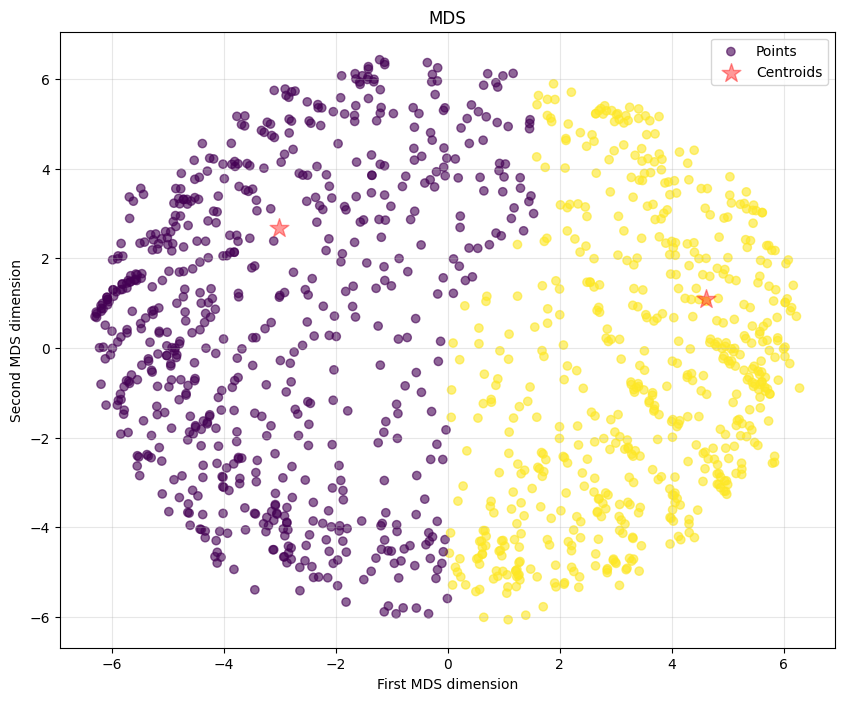

In [67]:
perform_analysis('continuous', 'bordaA', 2)

In [ ]:
perform_analysis('continuous', 'bordaP', 2)

In [ ]:
perform_analysis('continuous', 'hh', 2)

In [ ]:
perform_analysis('continuous_rest', 'bordaA', 2)

In [ ]:
perform_analysis('continuous_rest', 'bordaP', 2)

In [ ]:
perform_analysis('discrete', 'hh', 2)

In [ ]:
perform_analysis('discrete', 'bordaA', 2)

In [ ]:
perform_analysis('discrete', 'bordaP', 2)

### Uniqueness Analysis

In [ ]:
def generate_value_histogram(ballots, weights, bins, dim):
    """
    Generate a histogram of values for a given dimension.
    
    Parameters:
    ballots : numpy.ndarray
        A matrix where each row represents an individual ballot
        Shape: (total_ballots, n_candidates)
    weights : numpy.ndarray
        An array containing the count/weight of each ballot pattern
        Shape: (total_ballots,)
    dim : int
        The dimension index for which to generate the histogram
    """
    # Extract values for the given dimension
    values = ballots[:, dim]
    
    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=bins, weights=weights, edgecolor='black', alpha=0.7)
    plt.title(f'Value Distribution for Dimension {dim}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
def check_even_split(ballots, weights, value_set, dim):

    for v in value_set:
        # Count all with less or equal to v in dim
        less = np.sum(ballots[:, dim] <= v)
        # Count all with greater than v in dim
        greater = np.sum(ballots[:, dim] > v)
        if less == greater:
            return True
    
    return False

def check_all_even_split(ballots, weights, value_set):
    for dim in range(ballots.shape[1]):
        if not check_even_split(ballots, weights, value_set, dim):
            return False
    return True

In [ ]:
check_all_even_split(BALLOTS['bordaA'], weights, VALUE_SETS['bordaA'])

In [ ]:
check_all_even_split(BALLOTS['bordaP'], weights, VALUE_SETS['bordaP'])

In [ ]:
check_all_even_split(BALLOTS['hh'], weights, VALUE_SETS['hh'])

In [ ]:
def generate_cluster_histogram(model_type, embedding_type, num_clusters, dim):
    # Load model
    K = range(num_clusters)
    model = load_model(model_type, embedding_type, num_clusters)
    ballots = BALLOTS[embedding_type]
    
    z = extract_z_variables(model, DIMS[embedding_type], K, VALUE_SETS[embedding_type])
    
    if model_type == 'discrete':
        centroids = get_centroids_discrete(model, BALLOTS[embedding_type])
    else:
        centroids = extract_centroids(model, z, K, DIMS[embedding_type], VALUE_SETS[embedding_type])

    labels = assign_to_clusters(ballots, centroids)

    for i in range(num_clusters):
        mask = (labels == i)
        cluster_ballots = ballots[mask]
        cluster_weights = weights[mask]
        generate_value_histogram(cluster_ballots, cluster_weights, bins=VALUE_SETS[embedding_type], dim=dim)

def check_cluster_ambiguity(model_type, embedding_type, num_clusters):
    # Load model
    K = range(num_clusters)
    model = load_model(model_type, embedding_type, num_clusters)
    ballots = BALLOTS[embedding_type]
    
    z = extract_z_variables(model, DIMS[embedding_type], K, VALUE_SETS[embedding_type])
    
    if model_type == 'discrete':
        centroids = get_centroids_discrete(model, BALLOTS[embedding_type])
    else:
        centroids = extract_centroids(model, z, K, DIMS[embedding_type], VALUE_SETS[embedding_type])

    labels = assign_to_clusters(ballots, centroids)

    labels = assign_to_clusters(ballots, centroids)

    for i in range(num_clusters):
        mask = (labels == i)
        cluster_ballots = ballots[mask]
        cluster_weights = weights[mask]
        print(f"Cluster {i} Even Split: {check_all_even_split(cluster_ballots, cluster_weights, VALUE_SETS[embedding_type])}")

In [ ]:
check_cluster_ambiguity('continuous_rest', 'bordaP', 2)